In [3]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, XGBClassifier

pd.set_option('display.max_rows', 500)

In [4]:
# Importing data
df = pd.read_csv('InsNova_train.csv')
df = df.sample(frac=1.0)
df.loc[:, 'pure_premium'] = df['claim_cost'] / df['exposure']
df.loc[:, 'severity'] = df['claim_cost'] / np.fmax(df['claim_count'], 1)
df.loc[:, 'frequency'] = df['claim_count'] / df['exposure']
    
# Feature engineering
df['large_veh'] = np.where(df['veh_body'].isin(['MIBUS', 'MCARA', 'BUS']), 1, 0)
df['expensive_area'] = np.where(df['area'].isin(['E','F']), 1, 0)
df['expensive_age_risk'] = np.where(df['dr_age'].isin([1, 2]) & (df['veh_value'] > 5.0), 1, 0)
df['expensive_veh'] = np.where(df['veh_value'] > 6.0, 1, 0)
df['severe_veh'] = np.where(df['veh_body'].isin(['HDTOP', 'TRUCK', 'UTE']), 1, 0)
df['young_dr'] = np.where(df['dr_age'] == 1, 1, 0)
df['old_dr'] = np.where(df['dr_age'] > 4.0, 1, 0)
df['new_veh'] = np.where(df['veh_age'] < 2.0, 1, 0)
df['old_veh'] = np.where(df['veh_age'] == 4.0, 1, 0)
df['frequent_area'] = np.where(df['area'].isin(['B','F']), 1, 0)
df['young_dr_old_car'] = np.where((df['dr_age'] == 1) & (df['veh_age'] > 1.0), 1, 0)
df['young_m_old_car'] = np.where((df['dr_age'] == 1) & (df['veh_age'] > 1.0) & (df['gender'] == 'M'), 1, 0)
df['young_f_old_car'] = np.where((df['dr_age'] == 1) & (df['veh_age'] > 1.0) & (df['gender'] == 'F'), 1, 0)
df['frequent_body'] = np.where(df['veh_body'].isin(['BUS', 'COUPE', 'HDTOP', 'MCARA', 'PANVN', 'STNWG']), 1, 0)
df['infrequent_body'] = np.where(df['veh_body'].isin(['MIBUS', 'UTE']), 1, 0)
df['young_m'] = np.where((df['gender'] == 'M') & (df['dr_age'] < 3.0), 1, 0)

cat_cols = ['veh_body',
            'area',
            'gender',
            'large_veh',
            'expensive_area',
            'expensive_age_risk',
            'expensive_veh',
            'severe_veh',
            'young_dr',
            'old_dr',
            'new_veh',
            'old_veh',
            'frequent_area',
            'young_dr_old_car',
            'young_m_old_car',
            'young_f_old_car',
            'frequent_body',
            'infrequent_body',
            'young_m']

# Creating Categorical dataset for LightGBM and CatBoost
for i in cat_cols:
    df[i] = df[i].astype('category').cat.codes

# Splitting into pred/response
response_cols = ['exposure',
                 'claim_ind',
                 'claim_count',
                 'claim_cost',
                 'pure_premium',
                 'severity',
                 'frequency']
X, y = df.drop(response_cols, axis=1), df[response_cols]
X = X.drop('id', axis=1)
X['exposure'] = y['exposure'].copy()
pred_cols = ['veh_value', 'veh_age', 'dr_age'] + cat_cols
X_cont = X[pred_cols]
X_ind = X[pred_cols + ['exposure']]
sev_mask = y['claim_cost'] > 0.0

In [5]:
# Claim Ind
ind_model = XGBClassifier(n_estimators=500,
                          learning_rate=0.02,
                          subsample=0.67,
                          tree_method='hist',
                          scale_pos_weight= (y.shape[0] - y['claim_ind'].sum()) / y['claim_ind'].sum(),
                          max_depth=5,
                          colsample_bytree=0.5,
                          n_jobs=-1)
ind_model.fit(X_ind, y['claim_ind'])
ind_importances = pd.DataFrame({'feature': X_ind.columns, 'gain': ind_model.feature_importances_})
print(ind_importances.sort_values('gain', ascending=False))

               feature      gain
22            exposure  0.117779
0            veh_value  0.060327
16    young_dr_old_car  0.051285
18     young_f_old_car  0.048224
2               dr_age  0.046116
12              old_dr  0.045057
20     infrequent_body  0.042257
15       frequent_area  0.041009
4                 area  0.040947
17     young_m_old_car  0.040812
1              veh_age  0.040786
19       frequent_body  0.040713
3             veh_body  0.039744
10          severe_veh  0.038662
21             young_m  0.038316
13             new_veh  0.038037
11            young_dr  0.037511
7       expensive_area  0.036124
5               gender  0.035200
14             old_veh  0.034509
6            large_veh  0.029935
9        expensive_veh  0.028424
8   expensive_age_risk  0.028227


In [6]:
# Claim Freq
freq_model = XGBRegressor(n_estimators=500,
                          learning_rate=0.02,
                          subsample=0.67,
                          tree_method='hist',
                          objective='count:poisson',
                          max_depth=5,
                          colsample_bytree=0.5,
                          n_jobs=-1)
freq_model.fit(X_cont, y['frequency'], sample_weight=y['exposure'])
freq_importances = pd.DataFrame({'feature': X_cont.columns, 'gain': freq_model.feature_importances_})
print(freq_importances.sort_values('gain', ascending=False))

               feature      gain
0            veh_value  0.073067
12              old_dr  0.061694
2               dr_age  0.055931
4                 area  0.051618
3             veh_body  0.051314
5               gender  0.047385
16    young_dr_old_car  0.047295
17     young_m_old_car  0.046887
15       frequent_area  0.046120
21             young_m  0.045343
1              veh_age  0.043781
20     infrequent_body  0.043663
19       frequent_body  0.043613
7       expensive_area  0.043031
10          severe_veh  0.042857
11            young_dr  0.040441
13             new_veh  0.040412
6            large_veh  0.040270
18     young_f_old_car  0.038188
14             old_veh  0.034844
8   expensive_age_risk  0.034185
9        expensive_veh  0.028060


In [7]:
# Claim Freq (only claims)
freqc_model = XGBRegressor(n_estimators=500,
                          learning_rate=0.02,
                          subsample=0.67,
                          tree_method='hist',
                          objective='count:poisson',
                          max_depth=5,
                          colsample_bytree=0.5,
                          n_jobs=-1)
freqc_model.fit(X_cont.loc[sev_mask, :],
                y.loc[sev_mask, 'frequency'],
                sample_weight=y.loc[sev_mask, 'exposure'])
freqc_importances = pd.DataFrame({'feature': X_cont.columns, 'gain': freqc_model.feature_importances_})
print(freqc_importances.sort_values('gain', ascending=False))

               feature      gain
0            veh_value  0.085993
15       frequent_area  0.058342
2               dr_age  0.052799
5               gender  0.052582
3             veh_body  0.051523
16    young_dr_old_car  0.051283
19       frequent_body  0.050756
4                 area  0.049072
13             new_veh  0.048425
21             young_m  0.045826
1              veh_age  0.045452
14             old_veh  0.045375
12              old_dr  0.044996
18     young_f_old_car  0.044387
11            young_dr  0.041882
17     young_m_old_car  0.037994
7       expensive_area  0.037917
10          severe_veh  0.037884
20     infrequent_body  0.033345
8   expensive_age_risk  0.031660
6            large_veh  0.030346
9        expensive_veh  0.022159


In [8]:
# Claim Severity
sev_model = XGBRegressor(n_estimators=500,
                          learning_rate=0.02,
                          subsample=0.67,
                          tree_method='hist',
                          objective='reg:gamma',
                          max_depth=5,
                          colsample_bytree=0.5,
                          n_jobs=-1)
sev_model.fit(X_cont.loc[sev_mask, :],
              y.loc[sev_mask, 'severity'],
              sample_weight=y.loc[sev_mask, 'claim_count'])
sev_importances = pd.DataFrame({'feature': X_cont.columns, 'gain': sev_model.feature_importances_})
print(sev_importances.sort_values('gain', ascending=False))

               feature      gain
21             young_m  0.080033
8   expensive_age_risk  0.065353
0            veh_value  0.063574
10          severe_veh  0.059892
4                 area  0.054457
13             new_veh  0.052553
1              veh_age  0.050401
2               dr_age  0.049148
14             old_veh  0.047412
5               gender  0.046370
15       frequent_area  0.044122
7       expensive_area  0.044113
3             veh_body  0.042521
17     young_m_old_car  0.041887
20     infrequent_body  0.037078
18     young_f_old_car  0.036973
16    young_dr_old_car  0.035682
11            young_dr  0.034299
12              old_dr  0.033387
19       frequent_body  0.031352
6            large_veh  0.025564
9        expensive_veh  0.023830


Text(0.5, 0, 'Xgboost Feature Importance')

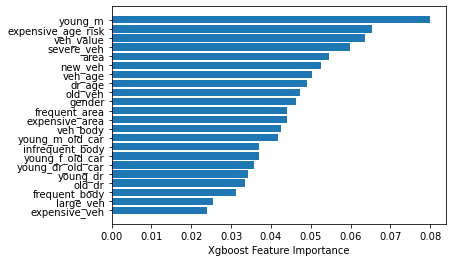

In [19]:
sorted_idx = sev_model.feature_importances_.argsort()
plt.barh(X_cont.columns[sorted_idx], sev_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [9]:
# Pure Premium
pp_model = XGBRegressor(n_estimators=500,
                        learning_rate=0.02,
                        subsample=0.67,
                        tree_method='hist',
                        objective='reg:tweedie',
                        tweedie_variance_power=1.7,
                        max_depth=5,
                        colsample_bytree=0.5,
                        n_jobs=-1)
pp_model.fit(X_cont.loc[sev_mask, :],
             y.loc[sev_mask, 'pure_premium'],
             sample_weight=y.loc[sev_mask, 'exposure'])
pp_importances = pd.DataFrame({'feature': X_cont.columns, 'gain': pp_model.feature_importances_})
print(pp_importances.sort_values('gain', ascending=False))

               feature      gain
8   expensive_age_risk  0.084957
21             young_m  0.068966
0            veh_value  0.066395
4                 area  0.052207
17     young_m_old_car  0.050391
1              veh_age  0.047130
7       expensive_area  0.046776
10          severe_veh  0.046359
2               dr_age  0.046043
20     infrequent_body  0.045743
5               gender  0.044907
13             new_veh  0.044601
3             veh_body  0.044398
15       frequent_area  0.042754
19       frequent_body  0.042584
12              old_dr  0.041841
11            young_dr  0.038316
16    young_dr_old_car  0.038079
14             old_veh  0.035857
6            large_veh  0.026279
18     young_f_old_car  0.025036
9        expensive_veh  0.020381


<BarContainer object of 22 artists>

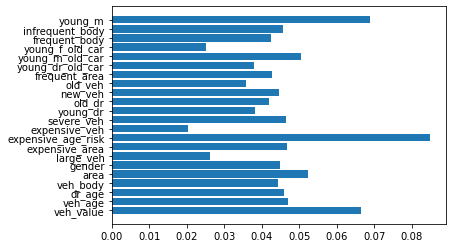

In [10]:
#pure_premium importance plot
plt.barh(X_cont.columns, pp_model.feature_importances_)

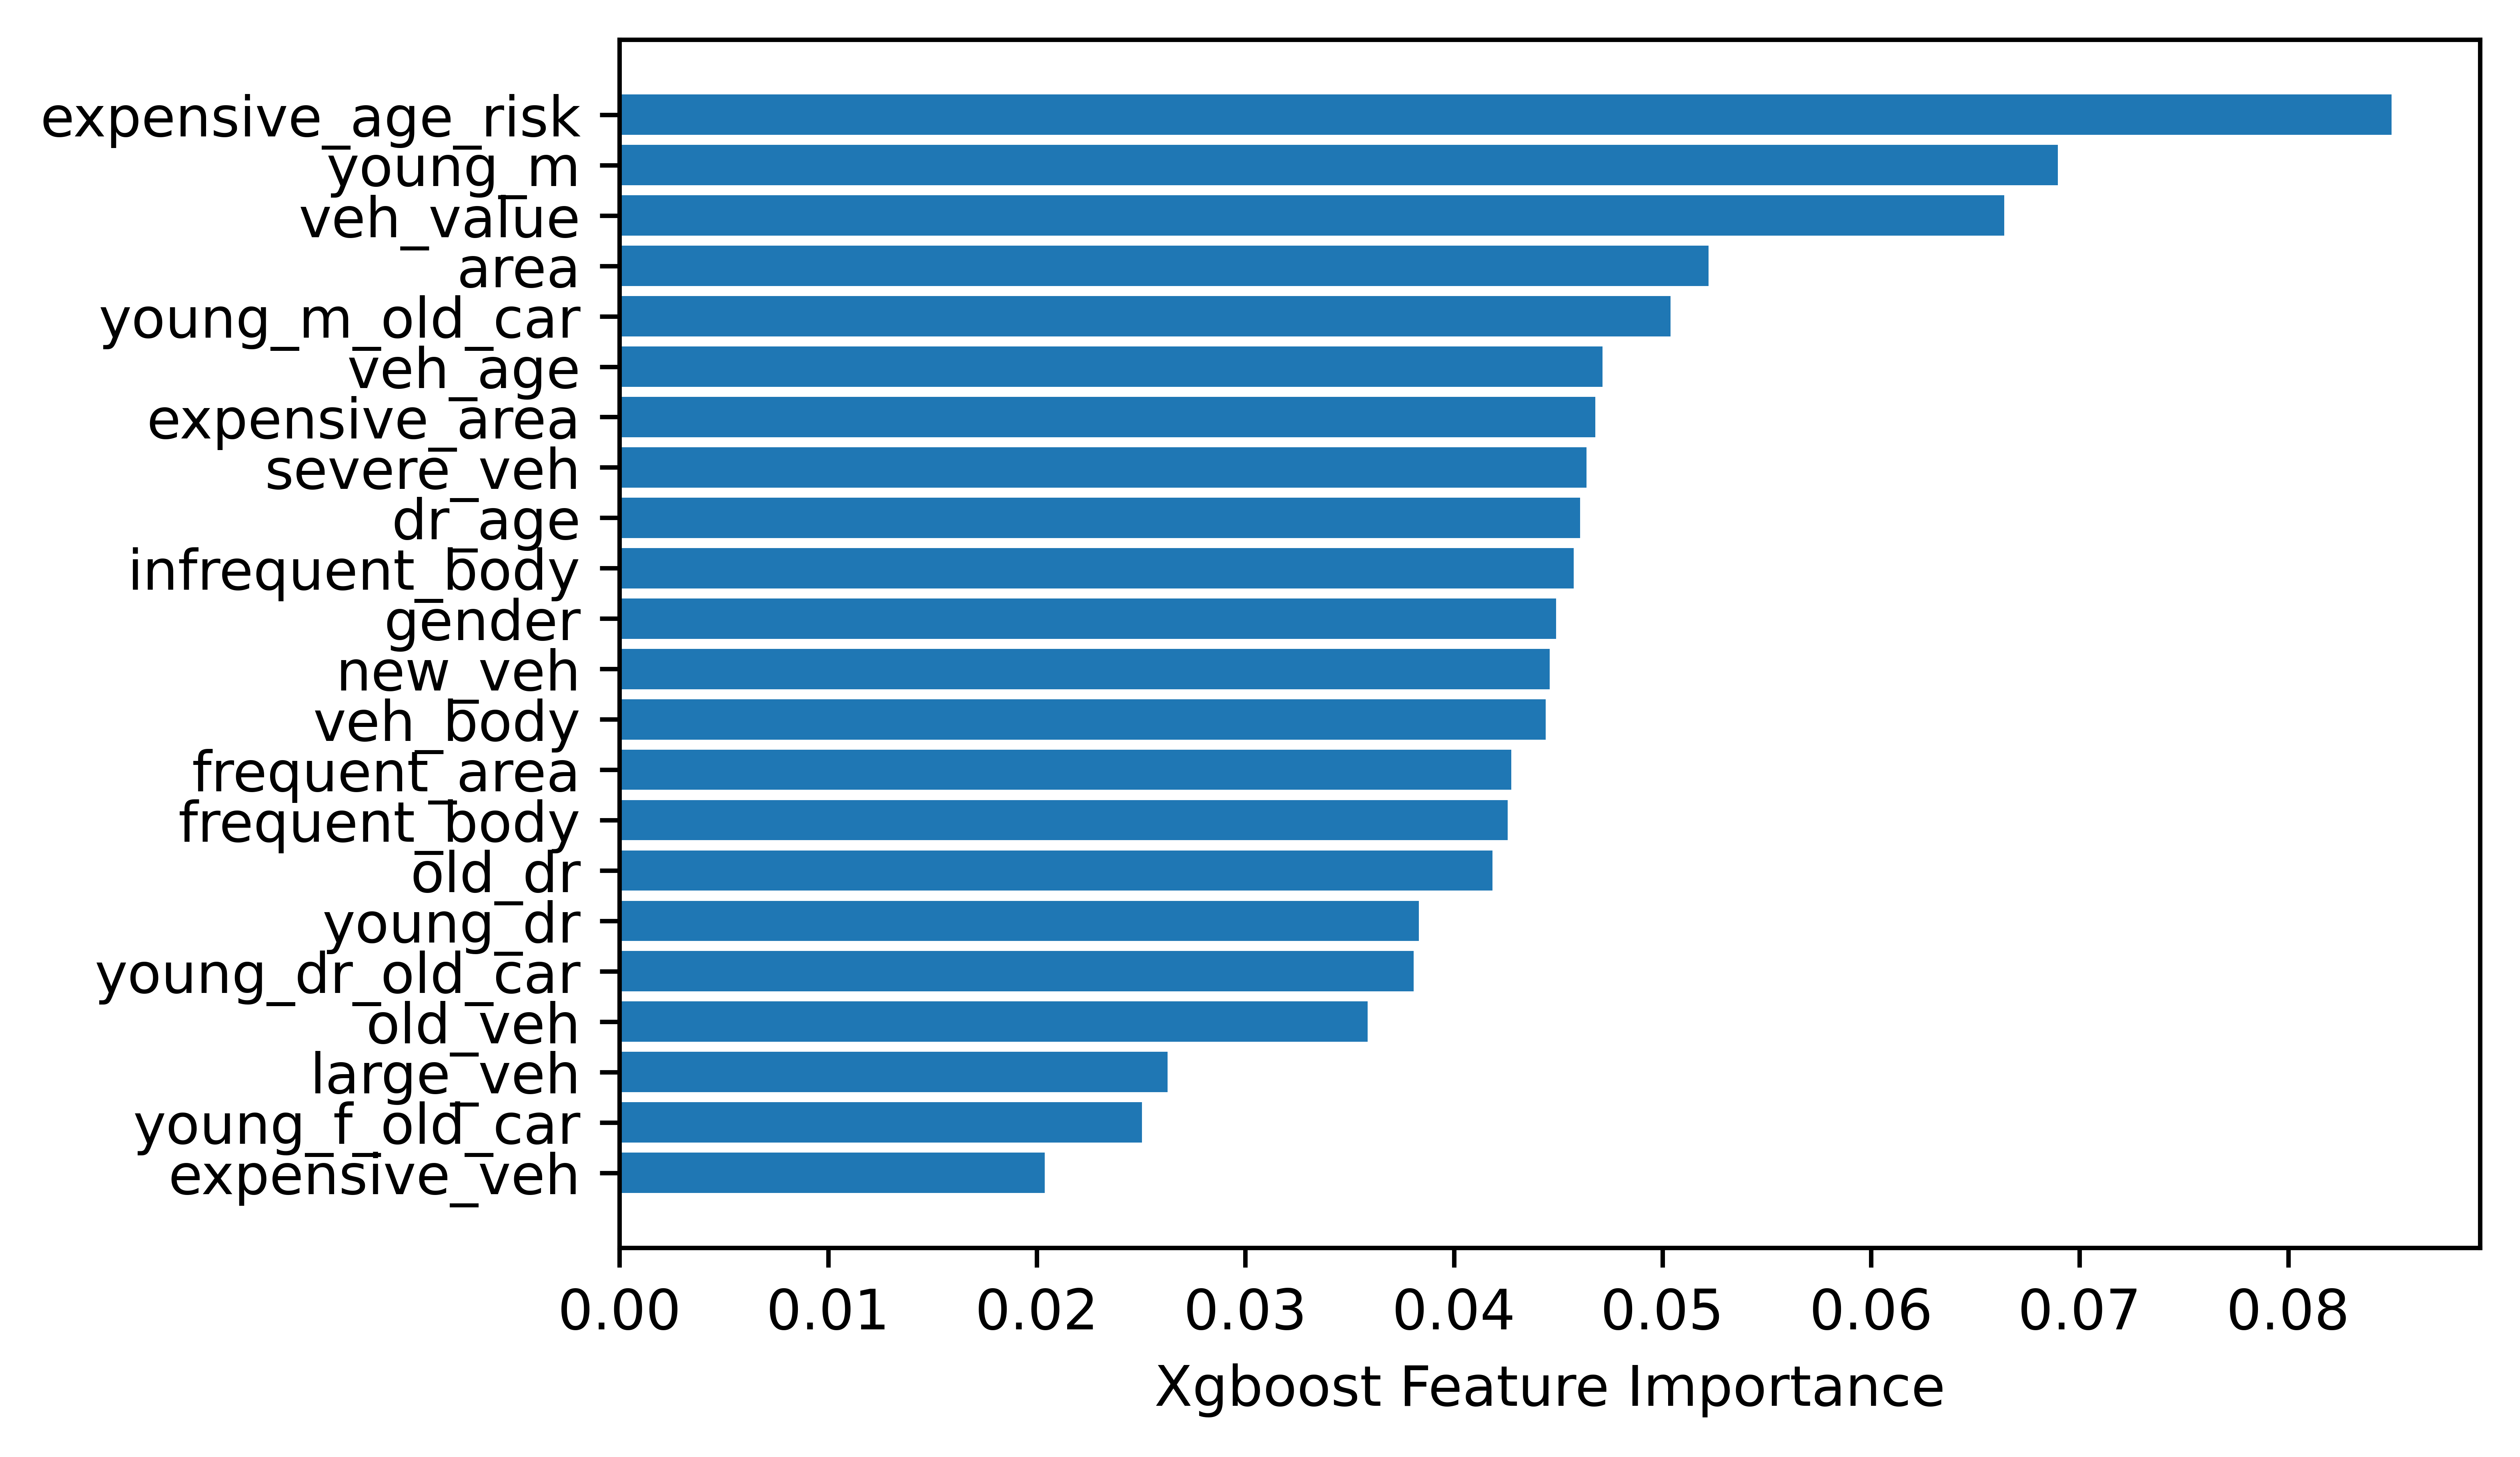

In [18]:
plt.figure(dpi=1000)
sorted_idx = pp_model.feature_importances_.argsort()
plt.barh(X_cont.columns[sorted_idx], pp_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.savefig('XGboost feature importance plot.png', bbox_inches='tight')
